In [ ]:
'''

'''

In [1]:
# 0. Get data

import pandas as pd
import numpy as np

from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import os
import sys
sys.path.append(os.path.abspath( '/mnt/c/Users/ochapman/Documents/Mesirov/Software/oscutils'))
import get
pd.set_option('display.max_columns', None)
#os.chdir('/home/ochapman/Documents/Mesirov/medullo_ecDNA/TCGA-lifelines-survival')
print(os.getcwd())

try:
    os.mkdir('out')
except OSError as error:
    print(error)

/mnt/c/Users/ochapman/Documents/Mesirov/medullo_ecDNA/src/survival
[Errno 17] File exists: 'out'


In [2]:
def get_pfs(censor_years=None):
    pfs = get.medullo_patients()
    pfs.ecDNA = pfs.ecDNA.map({
        'yes':True,
    }).fillna(False).astype(bool)
    pfs = pfs.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])
    pfs.Vital_status = pfs.Vital_status.map({
        'alive':False,
        'deceased':True
    })
    # event observed if patient has documented relapse or dies.
    pfs.Relapse_status = pfs.apply(axis=1,
                                   func=lambda x:  (not (np.isnan(x["Relapse_interval_years"]))) or x['Vital_status'])
    pfs['Relapse_interval_years'] = pfs.apply(axis=1,
                                              func=lambda x: x['Survival_time_years'] if np.isnan(x['Relapse_interval_years']) else x['Relapse_interval_years'])
    if type(censor_years) == int:
        rows = (pfs['Relapse_interval_years'] > censor_years)
        print("Right-censoring {} intervals to {} years...".format(rows.sum(),censor_years))
        pfs.loc[rows,'Relapse_status'] = False
        pfs.loc[rows,'Relapse_interval_years'] = censor_years
    return pfs

def get_os(censor_years=None):
    os_tbl = get.medullo_patients()
    os_tbl.ecDNA = os_tbl.ecDNA.map({
        'yes':True,
    }).fillna(False).astype(bool)
    os_tbl = os_tbl.dropna(subset=['Survival_time_years','ecDNA'])
    os_tbl.Vital_status = os_tbl.Vital_status.map({
        'alive':False,
        'deceased':True
    }).fillna(False).astype(bool)
    os_tbl = os_tbl.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])
    if type(censor_years) == int:
        rows = (os_tbl['Survival_time_years'] > censor_years)
        print("Right-censoring {} intervals to {} years...".format(rows.sum(),censor_years))
        os_tbl.loc[rows,'Vital_status'] = False
        os_tbl.loc[rows,'Survival_time_years'] = censor_years
    return os_tbl

def get_p53_mut(samples):
    '''
    Return series of samples annotated with p53 status (p53-wt, p53-mut)
    '''
    df = get.medullo_p53()
    # Include only samples for which germline and somatic mutations are available
    df = df[(df.somatic_mut_available) & (df.germline_mut_available)]
    # compute p53 status
    df['somatic_tp53_mut'] = df['somatic_tp53_mut'].fillna(False)
    df['p53_mut'] = df.somatic_tp53_mut.astype(bool) | df['ClinVAR/VEP'].astype(bool)    # subset
    df = df[df.index.isin(samples)]
    return df.p53_mut
def annotate_p53_mut(df):
    p53_status = get_p53_mut(df.index).map(int)
    df = df.join(p53_status,how='inner')
    return df


def map_cbtn(key=None,value=None):
    df = get.medullo_samples()
    df=df[df.index.map(lambda x: str(x).startswith('BS'))]
    if key == None or value == None:
        return df
    else:
        df["Sample_ID"] = df.index
        return df.set_index(key)[value].to_dict()
def preprocess_ac(df):
    # drop ampliconx suffix
    df['sample_name']=df['sample_name'].map(lambda x: '_'.join(x.split('_')[:-1]))
    # drop feature suffix
    df['feature']=df['feature'].map(lambda x: x.split('_')[0])
    # map cbtn sample names
    d=map_cbtn('Aliases','Sample_ID')
    df['sample_name']=df['sample_name'].map(lambda x: d[x] if x in d.keys() else x)
    df['sample_name']=df['sample_name'].map(lambda x: x.split('.')[0])
    # map grch37 ids
    df['sample_name']=df['sample_name'].map(lambda x: x[:-3] if x.endswith('_AA') else x)
    # map patient ids
    d=get.medullo_samples()['Patient_ID'].to_dict()
    df['Patient_ID']=df['sample_name'].map(lambda x: d[x] if x in d.keys() else x)
    return df
def get_MYC_amp_patients():
    DIR="/home/ochapman/Documents/Mesirov/medullo_ecDNA/data/AmpliconClassifier/latest"
    hg38_set=pd.read_csv(DIR+"/hg38_gene_list.tsv",sep='\t')
    hg38_set=preprocess_ac(hg38_set)
    hg38_set=hg38_set[hg38_set.gene=='MYC']
    pts = set(hg38_set['Patient_ID'])
    hg19_set=pd.read_csv(DIR+'/grch37_gene_list.tsv',sep='\t')
    hg19_set=preprocess_ac(hg19_set)
    hg19_set=hg19_set[hg19_set.gene=='MYC']
    pts = pts | set(hg19_set['Patient_ID']) | set(['MB106','MB260'])
    return pts
def get_MYCN_amp_patients():
    DIR="/home/ochapman/Documents/Mesirov/medullo_ecDNA/data/AmpliconClassifier/latest"
    hg38_set=pd.read_csv(DIR+"/hg38_gene_list.tsv",sep='\t')
    hg38_set=preprocess_ac(hg38_set)
    hg38_set=hg38_set[hg38_set.gene=='MYCN']
    pts = set(hg38_set['Patient_ID'])
    hg19_set=pd.read_csv(DIR+'/grch37_gene_list.tsv',sep='\t')
    hg19_set=preprocess_ac(hg19_set)
    hg19_set=hg19_set[hg19_set.gene=='MYCN']
    pts=pts | set(hg19_set['Patient_ID'])
    return pts
def annotate_myc_amp(df):
    myc_amp = get_MYC_amp_patients()
    df['myc_amp'] = df.index.isin(myc_amp)
    return df
def annotate_mycn_amp(df):
    mycn_amp = get_MYCN_amp_patients()
    df['mycn_amp'] = df.index.isin(mycn_amp)
    return df

# Cox regression: need to one-hot encode categorical (Subgroup) and Sex. Age as integer.
def cox_transform(tbl,outcome):
    '''
    Transform survival data for Cox analysis. 
    outcome: string. 'PFS' or 'OS'
    returns: tbl
    '''
    tbl=tbl.copy()
    tbl = tbl.dropna(subset=['Survival_time_years','ecDNA','Subgroup','Sex','Age_at_diagnosis'])
    tbl["Sex"] = tbl["Sex"].map({
        "f":0,
        "m":1,
    }).astype(int)
    tbl["WNT"] = tbl["Subgroup"] == 'WNT'
    tbl["SHH"] = tbl["Subgroup"] == 'SHH'
    tbl["G3"] = tbl["Subgroup"] == "G3"
    tbl["G4"] = tbl["Subgroup"] == 'G4'
    
    # drop WNT and unknown subgroup
    tbl=tbl[tbl.SHH | tbl.G3 | tbl.G4]
    
    if outcome == 'PFS':
        pfs = tbl[["ecDNA","Relapse_interval_years","Relapse_status","Age_at_diagnosis","Sex","SHH","G3","p53_mut","myc_amp","mycn_amp"]]
        return pfs
    elif outcome == 'OS':
        ost = tbl[["ecDNA","Vital_status","Survival_time_years","Age_at_diagnosis","Sex","SHH","G3","p53_mut","myc_amp","mycn_amp"]]
        return ost

def median_time_to_event(T,E):
    medIx = np.argsort(T)[len(T)//2]
    med=T[medIx]
    obs=E[medIx]
    if obs:
        print("Median time to event:",med)
    else:
        print("Median time to event is at least:",med,"(event not observed at median)")
    return(med,obs)

def plot_cph(cph):
    ax = cph.plot()
    sns.despine()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    ax.set_xlabel("log hazard ratio (95% CI)")
    return ax

def cph(tbl, outcome, outfile=None, formula=None):
    cph = CoxPHFitter()
    if outcome=='PFS':
        duration_col='Relapse_interval_years'
        event_col='Relapse_status'
    elif outcome=='OS':
        duration_col='Survival_time_years'
        event_col='Vital_status'
    else:
        raise InputError('outcome must be PFS or OS.')
    if formula==None:
        cph.fit(tbl, duration_col=duration_col, event_col=event_col,
                step_size=0.1)
    else:
        cph.fit(tbl, duration_col=duration_col, event_col=event_col,
               formula=formula, step_size=0.1)
    cph.print_summary()  # access the results using cph.summary
        
    ax = plot_cph(cph)
    
    if outfile != None:
        cph.summary.to_csv(outfile+'.tsv',sep='\t')
        plt.savefig(outfile+'.svg')
    return cph

# Cox models on sex, subgroup, and age
No p53 mutation or myc family amplification

Right-censoring 74 intervals to 5 years...


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 301 total observations, 222 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
      baseline estimation = breslow
   number of observations = 301
number of events observed = 79
   partial log-likelihood = -396.56
         time fit was run = 2022-10-06 21:36:32 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
G3                 1.44       4.22       0.29             0.87             2.01                 2.38                 7.49
SHH                0.98       2.68       0.31             0.37             1.60                 1.44                 4.96
Sex               -0.13       0.88       0.24            -0.60             0.34                 0.55                 1.40
ecDNA              0.86       2.36       0.25             0.38             1.34                 1.46                 3.81

                     z      p   -log2(p)
covariate                               
Age_at_diagnosis  0.62   0.54       0.90
G3                4.93 <0.005      20.19
SHH               3.13 <0.005       9.14
Sex              -0.55   0.58       0.78
ecDNA             3.49 <0.005      11.04
---
Concordance = 0.71
Partial AIC = 803.12
log-likelihood ratio test = 39.95 on 5 df
-log2(p) of ll-ratio test = 22.64

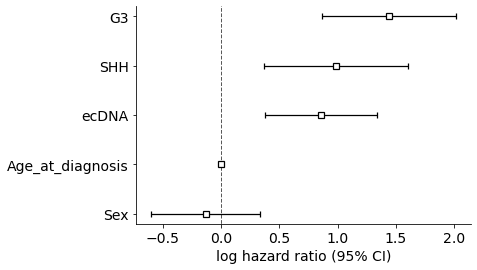

In [3]:
pfs = get_pfs(censor_years=5)
pfs = annotate_p53_mut(pfs)
pfs = annotate_myc_amp(pfs)
pfs = annotate_mycn_amp(pfs)
pfs = cox_transform(pfs,outcome='PFS')
formula="SHH + G3 + Sex + Age_at_diagnosis + ecDNA"
model = cph(pfs,'PFS',formula=formula,outfile='out/cph_pfs_1')

Right-censoring 78 intervals to 5 years...


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 301 total observations, 238 right-censored observations>
             duration col = 'Survival_time_years'
                event col = 'Vital_status'
      baseline estimation = breslow
   number of observations = 301
number of events observed = 63
   partial log-likelihood = -307.13
         time fit was run = 2022-10-06 21:37:03 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
G3                 1.76       5.79       0.32             1.12             2.39                 3.07                10.93
SHH                0.67       1.96       0.38            -0.07             1.41                 0.94                 4.10
Sex               -0.37       0.69       0.27            -0.89             0.15                 0.41                 1.17
ecDNA              1.10       2.99       0.27             0.57             1.62                 1.77                 5.07

                     z      p   -log2(p)
covariate                               
Age_at_diagnosis  1.25   0.21       2.25
G3                5.42 <0.005      23.97
SHH               1.79   0.07       3.75
Sex              -1.38   0.17       2.59
ecDNA             4.07 <0.005      14.39
---
Concordance = 0.75
Partial AIC = 624.26
log-likelihood ratio test = 48.54 on 5 df
-log2(p) of ll-ratio test = 28.43

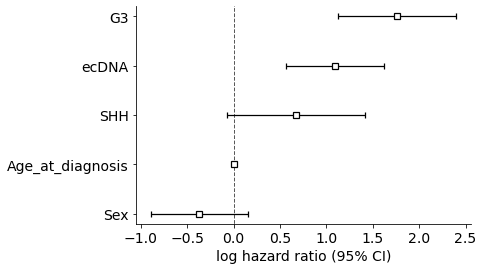

In [4]:
ost = get_os(censor_years=5)
ost = annotate_p53_mut(ost)
ost = annotate_myc_amp(ost)
ost = annotate_mycn_amp(ost)
ost = cox_transform(ost,outcome='OS')
formula="SHH + G3 + Sex + Age_at_diagnosis + ecDNA"
model = cph(ost,'OS',formula=formula,outfile='out/cph_os_1')

# Cox models on age, sex, subgroup, and p53
Collinearity controlled by l2 ridge regression.

In [5]:
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import GridSearchCV

def cph_l2penalty_xvalidation(tbl,outcome,formula=None,lambdas=None):
    '''
    For use on collinear data.
    Returns a CPH model with an L2 penalty lambda, where lambda is chosen empirically using 5-fold cross-validation.
    '''
    # default search space
    if lambdas==None:
        lambdas = 2.0 ** np.arange(-10, 10)
    if outcome=='PFS':
        duration_col='Relapse_interval_years'
        event_col='Relapse_status'
    elif outcome=='OS':
        duration_col='Survival_time_years'
        event_col='Vital_status'
    # sklearn adapter for lifelines
    X = tbl.drop(duration_col,axis=1)
    Y = tbl[event_col]
    base_class = sklearn_adapter(CoxPHFitter, event_col=event_col)
    wf = base_class()
    if formula == None:
        clf = GridSearchCV(wf, {
           "penalizer": lambdas,
           #"strata":[[],['p53_mut']]
        }, cv=5, error_score='raise')
    else:
        print(f"FORMULA! {formula}")
        clf = GridSearchCV(wf, {
           "penalizer": lambdas,
           "formula": [formula],
           #"strata":[[],['p53_mut']]
        }, cv=5, verbose=1)
    clf.fit(X, Y)

    return clf

from lifelines.utils import k_fold_cross_validation
import statistics
import numpy as np
def cph_l2penalty_xvalidation(tbl,outcome,formula,lambdas=None):
    # default search space
    if lambdas==None:
        lambdas = np.insert(2.0 ** np.arange(-10, 10),0,0)
    if outcome=='PFS':
        duration_col='Relapse_interval_years'
        event_col='Relapse_status'
    elif outcome=='OS':
        duration_col='Survival_time_years'
        event_col='Vital_status'
    cph = CoxPHFitter()
        
    scores = k_fold_cross_validation([CoxPHFitter(penalizer=x) for x in lambdas], tbl, 
                                     duration_col=duration_col, event_col=event_col, k=10, scoring_method="log_likelihood",
                                     fitter_kwargs={"formula":formula,"step_size":0.1})#,seed=47)
    scores = [statistics.mean(x) for x in scores]
    print(f"scores:{list(zip(lambdas,scores))}")
    best_i=np.argmax(scores)
    print(f"max:{(lambdas[best_i],scores[best_i])}")
    return lambdas[best_i],scores[best_i]

## PFS

In [6]:
pfs = get_pfs(censor_years=5)
pfs = annotate_p53_mut(pfs)
pfs = annotate_myc_amp(pfs)
pfs = annotate_mycn_amp(pfs)
pfs = cox_transform(pfs,outcome='PFS')

Right-censoring 74 intervals to 5 years...


In [7]:
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut'
sk_cph = cph_l2penalty_xvalidation(pfs,outcome='PFS',formula=formula)

scores:[(0.0, -0.7211490094010999), (0.0009765625, -0.7210901828642281), (0.001953125, -0.7210363238999494), (0.00390625, -0.720942486111011), (0.0078125, -0.7208040753051587), (0.015625, -0.7206847539781075), (0.03125, -0.7208678475929293), (0.0625, -0.7220879997834486), (0.125, -0.7256179426157521), (0.25, -0.7327957108305703), (0.5, -0.7437579155967263), (1.0, -0.7563182169450673), (2.0, -0.7670509828060128), (4.0, -0.7742706929553573), (8.0, -0.7784675287560243), (16.0, -0.7807288304147773), (32.0, -0.7819021770807704), (64.0, -0.7824997656018295), (128.0, -0.7828013183727405), (256.0, -0.7829527880698722), (512.0, -0.7830286967049099)]
max:(0.015625, -0.7206847539781075)


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 301 total observations, 222 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
                penalizer = 0.03125
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 301
number of events observed = 79
   partial log-likelihood = -396.27
         time fit was run = 2022-10-06 21:42:18 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
G3                 1.20       3.33       0.26             0.70             1.71                 2.01                 5.53
SHH                0.54       1.71       0.30            -0.05             1.12                 0.95                 3.08
Sex               -0.15       0.86       0.22            -0.59             0.29                 0.55                 1.33
ecDNA              0.63       1.87       0.26             0.13             1.13                 1.13                 3.10
p53_mut            1.07       2.92       0.41             0.27             1.87                 1.31                 6.52

                     z      p   -log2(p)
covariate                               
Age_at_diagnosis  0.19   0.85       0.24
G3                4.66 <0.005      18.29
SHH               1.80   0.07       3.80
Sex              -0.68   0.50       1.01
ecDNA             2.45   0.01       6.14
p53_mut           2.61   0.01       6.79
---
Concordance = 0.72
Partial AIC = 804.53
log-likelihood ratio test = 40.54 on 6 df
-log2(p) of ll-ratio test = 21.42

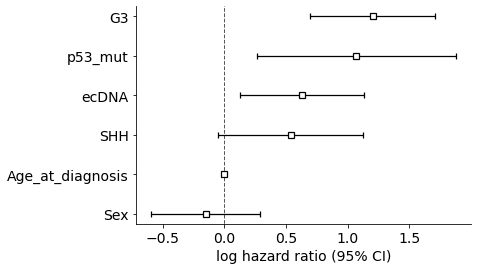

In [9]:
# max:(0.03125, -0.7312563625812042)
# max:(0.03125, -0.7229930623748085)
# max:(0.03125, -0.7276445357549282)
# max:(0.03125, -0.7248310475153698)

model = CoxPHFitter(penalizer=0.03125)
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut'
model.fit(pfs, duration_col='Relapse_interval_years', event_col='Relapse_status',formula=formula)
model.print_summary()  # access the results using cph.summary

ax = plot_cph(model)
outfile='out/cph_pfs_2_l2'
model.summary.to_csv(outfile+'.tsv',sep='\t')
plt.savefig(outfile+'.svg')

In [ ]:
# using MLE estimator
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut'
model = cph(pfs,'PFS',formula=formula)

## Overall survival

In [10]:
ost = get_os(censor_years=5)
ost = annotate_p53_mut(ost)
ost = annotate_myc_amp(ost)
ost = annotate_mycn_amp(ost)
ost = cox_transform(ost,outcome='OS')

Right-censoring 78 intervals to 5 years...


In [11]:
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut'
sk_cph = cph_l2penalty_xvalidation(ost,outcome='OS',formula=formula)

scores:[(0.0, -0.5523469964140963), (0.0009765625, -0.5521760283407783), (0.001953125, -0.5520168196454014), (0.00390625, -0.5517309454027804), (0.0078125, -0.551273126244345), (0.015625, -0.5507147079280962), (0.03125, -0.5505345679585971), (0.0625, -0.5520411297878799), (0.125, -0.5573939434156977), (0.25, -0.5683015488616388), (0.5, -0.5835743521752893), (1.0, -0.5988098606673318), (2.0, -0.6102385007220887), (4.0, -0.6173157516469719), (8.0, -0.621256365276385), (16.0, -0.6233350421993227), (32.0, -0.6244024486699794), (64.0, -0.6249432895013621), (128.0, -0.625215509280595), (256.0, -0.6253520708739954), (512.0, -0.6254204648289992)]
max:(0.03125, -0.5505345679585971)


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 301 total observations, 238 right-censored observations>
             duration col = 'Survival_time_years'
                event col = 'Vital_status'
                penalizer = 0.03125
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 301
number of events observed = 63
   partial log-likelihood = -307.14
         time fit was run = 2022-10-06 21:43:43 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
G3                 1.46       4.31       0.28             0.92             2.01                 2.50                 7.43
SHH                0.12       1.13       0.35            -0.57             0.82                 0.56                 2.26
Sex               -0.34       0.71       0.25            -0.83             0.14                 0.44                 1.15
ecDNA              0.84       2.32       0.27             0.31             1.38                 1.36                 3.97
p53_mut            1.33       3.78       0.47             0.41             2.25                 1.51                 9.48

                     z      p   -log2(p)
covariate                               
Age_at_diagnosis  0.71   0.48       1.07
G3                5.26 <0.005      22.69
SHH               0.35   0.73       0.46
Sex              -1.39   0.16       2.61
ecDNA             3.08 <0.005       8.92
p53_mut           2.84 <0.005       7.78
---
Concordance = 0.76
Partial AIC = 626.28
log-likelihood ratio test = 48.52 on 6 df
-log2(p) of ll-ratio test = 26.68

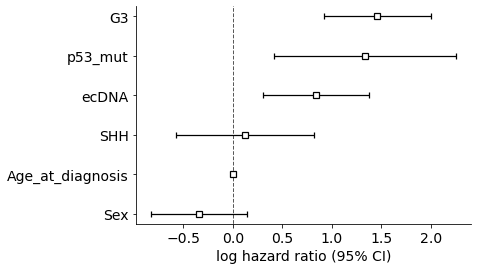

In [12]:
# max:(0.03125, -0.5505345679585971)

model = CoxPHFitter(penalizer=0.03125)
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut'
model.fit(ost, duration_col='Survival_time_years', event_col='Vital_status',formula=formula)
model.print_summary()  # access the results using cph.summary

ax = plot_cph(model)
outfile='out/cph_os_2_l2'
model.summary.to_csv(outfile+'.tsv',sep='\t')
plt.savefig(outfile+'.svg')

In [ ]:
# using MLE estimator
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut'
model = cph(ost,'OS',formula=formula)

# Cox models on age, sex, subgroup, p53, and myc family amp
Collinearity controlled by l2 ridge regression.

## PFS

In [13]:
pfs = get_pfs(censor_years=5)
pfs = annotate_p53_mut(pfs)
pfs = annotate_myc_amp(pfs)
pfs = annotate_mycn_amp(pfs)
pfs = cox_transform(pfs,outcome='PFS')

Right-censoring 74 intervals to 5 years...


In [14]:
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut + myc_amp + mycn_amp'
sk_cph = cph_l2penalty_xvalidation(pfs,outcome='PFS',formula=formula)

scores:[(0.0, -0.7146102006403307), (0.0009765625, -0.7144584950144627), (0.001953125, -0.7143132326890134), (0.00390625, -0.7140408229512438), (0.0078125, -0.713561000210609), (0.015625, -0.7128137802796275), (0.03125, -0.7119146203341847), (0.0625, -0.7114476523189308), (0.125, -0.7127367040727726), (0.25, -0.7178409468574003), (0.5, -0.7287563003985956), (1.0, -0.7442454838668465), (2.0, -0.7587590781137372), (4.0, -0.7687938207904879), (8.0, -0.7746724037982554), (16.0, -0.7778479379590922), (32.0, -0.779497296044924), (64.0, -0.780337680538201), (128.0, -0.780761836975512), (256.0, -0.7809749109277242), (512.0, -0.7810816974201997)]
max:(0.0625, -0.7114476523189308)


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 301 total observations, 222 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
                penalizer = 0.0625
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 301
number of events observed = 79
   partial log-likelihood = -392.43
         time fit was run = 2022-10-06 21:48:51 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age_at_diagnosis  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
G3                 0.94       2.57       0.24             0.47             1.42                 1.60                 4.15
SHH                0.47       1.60       0.27            -0.06             1.01                 0.94                 2.73
Sex               -0.25       0.78       0.22            -0.68             0.18                 0.51                 1.20
ecDNA              0.32       1.38       0.28            -0.22             0.87                 0.80                 2.38
myc_amp            1.54       4.64       0.41             0.74             2.33                 2.09                10.31
mycn_amp           0.33       1.40       0.42            -0.49             1.16                 0.61                 3.19
p53_mut            1.11       3.03       0.40             0.33             1.89                 1.39                 6.61

                     z      p   -log2(p)
covariate                               
Age_at_diagnosis -0.06   0.95       0.07
G3                3.88 <0.005      13.23
SHH               1.73   0.08       3.57
Sex              -1.12   0.26       1.94
ecDNA             1.17   0.24       2.05
myc_amp           3.78 <0.005      12.61
mycn_amp          0.79   0.43       1.22
p53_mut           2.78   0.01       7.52
---
Concordance = 0.72
Partial AIC = 800.87
log-likelihood ratio test = 48.20 on 8 df
-log2(p) of ll-ratio test = 23.40

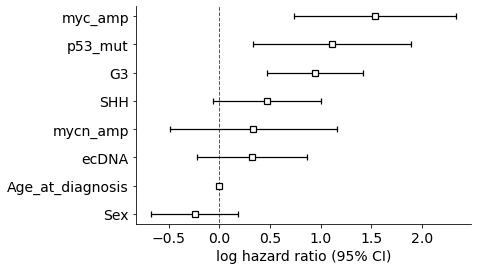

In [20]:
# Convergence error with step size 1. Changed to 0.1
# max:(0.0625, -0.718301168348367)
# max:(0.0625, -0.7152202671680876)
#max:(0.0625, -0.7152511141948331)

model = CoxPHFitter(penalizer=0.0625)
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut + myc_amp + mycn_amp'
model.fit(pfs, duration_col='Relapse_interval_years', event_col='Relapse_status',formula=formula)
model.print_summary()  # access the results using cph.summary

ax = plot_cph(model)
outfile='out/cph_pfs_3_l2'
model.summary.to_csv(outfile+'.tsv',sep='\t')
plt.savefig(outfile+'.svg')

In [ ]:
# using MLE estimator
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut + myc_amp + mycn_amp'
model = cph(pfs,'PFS',formula=formula)

## OS

In [16]:
ost = get_os(censor_years=5)
ost = annotate_p53_mut(ost)
ost = annotate_myc_amp(ost)
ost = annotate_mycn_amp(ost)
ost = cox_transform(ost,outcome='OS')

Right-censoring 78 intervals to 5 years...


In [17]:
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut + myc_amp + mycn_amp'
sk_cph = cph_l2penalty_xvalidation(ost,outcome='OS',formula=formula)

scores:[(0.0, -0.5448455368618714), (0.0009765625, -0.5446446932855781), (0.001953125, -0.5444536006069467), (0.00390625, -0.5440986816248627), (0.0078125, -0.5434859284337112), (0.015625, -0.5425743055086778), (0.03125, -0.5416195680800538), (0.0625, -0.5416140906429859), (0.125, -0.5445533925200753), (0.25, -0.5528264594051233), (0.5, -0.5675721937071962), (1.0, -0.585661853248707), (2.0, -0.6008117358834814), (4.0, -0.6105833065247805), (8.0, -0.6161029074623223), (16.0, -0.6190309636840319), (32.0, -0.6205382144221675), (64.0, -0.6213027857254327), (128.0, -0.6216878250982306), (256.0, -0.6218810353506599), (512.0, -0.6219778133841514)]
max:(0.0625, -0.5416140906429859)


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 301 total observations, 238 right-censored observations>
             duration col = 'Survival_time_years'
                event col = 'Vital_status'
                penalizer = 0.0625
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 301
number of events observed = 63
   partial log-likelihood = -303.32
         time fit was run = 2022-10-06 21:48:45 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
G3                 1.15       3.15       0.26             0.64             1.66                 1.89                 5.24
SHH                0.11       1.12       0.31            -0.50             0.72                 0.61                 2.06
Sex               -0.43       0.65       0.24            -0.90             0.04                 0.41                 1.04
ecDNA              0.46       1.58       0.29            -0.12             1.04                 0.89                 2.82
myc_amp            1.70       5.49       0.43             0.87             2.54                 2.38                12.64
mycn_amp           0.36       1.43       0.45            -0.53             1.24                 0.59                 3.45
p53_mut            1.32       3.75       0.45             0.44             2.20                 1.55                 9.05

                     z      p   -log2(p)
covariate                               
Age_at_diagnosis  0.42   0.68       0.56
G3                4.42 <0.005      16.62
SHH               0.36   0.72       0.47
Sex              -1.79   0.07       3.77
ecDNA             1.55   0.12       3.05
myc_amp           4.00 <0.005      13.96
mycn_amp          0.79   0.43       1.22
p53_mut           2.94 <0.005       8.25
---
Concordance = 0.77
Partial AIC = 622.64
log-likelihood ratio test = 56.16 on 8 df
-log2(p) of ll-ratio test = 28.50

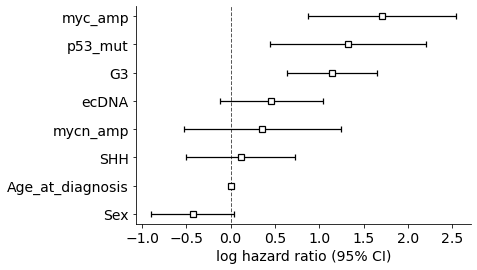

In [19]:
# Convergence error at step size 1. Set step size to 0.1
# max:(0.0625, -0.5405187820096812)
# max:(0.0625, -0.5380273601683264)

model = CoxPHFitter(penalizer=0.0625)
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut + myc_amp + mycn_amp'
model.fit(ost, duration_col='Survival_time_years', event_col='Vital_status',formula=formula)
model.print_summary()  # access the results using cph.summary

ax = plot_cph(model)
outfile='out/cph_os_3_l2'
model.summary.to_csv(outfile+'.tsv',sep='\t')
plt.savefig(outfile+'.svg')

In [ ]:
# using MLE estimator
formula='SHH + G3 + Sex + Age_at_diagnosis + ecDNA + p53_mut + myc_amp + mycn_amp'
model = cph(ost,'OS',formula=formula)

# Strata
Strata can address covariates where the proportional hazards assumption is violated.

In [ ]:
def stratified_cph_pfs(pfs, outfile=None):
    cph = CoxPHFitter()
    cph.fit(pfs, duration_col='Relapse_interval_years', event_col='Relapse_status',strata='p53_mut')
    cph.print_summary()  # access the results using cph.summary
        
    ax = plot_cph(cph)
    
    if outfile != None:
        cph.summary.to_csv(outfile+'.tsv',sep='\t')
        plt.savefig(outfile+'.svg')
    return cph

In [ ]:
pfs = get_pfs(censor_years=5)
pfs = annotate_p53_mut(pfs)
pfs = pfs_cox_transform_p53(pfs)
model_p53 = cph_pfs(pfs)

In [ ]:
stratified = stratified_cph_pfs(pfs)